In [39]:
import pickle


## Load pickle
with open("data.pickle","rb") as fr:
    df = pickle.load(fr)
df

,ID,Year_prd,Year_model,Brand,Model,City,Area,Mileage,CC,Fuel_CNG,Fuel_Diesel,Fuel_Gasoline,Fuel_Hybrid,Fuel_LPG,Price
0,TRAIN_00000,2018,2014,16,47,1214,12,85231,999,0,0,1,0,0,51.74
1,TRAIN_00001,2010,2006,17,20,2137,13,135000,1598,0,0,1,0,0,41.47
2,TRAIN_00002,2002,2002,9,36,785,15,255223,1796,0,0,1,0,0,17.81
3,TRAIN_00003,2006,2001,11,133,546,15,238000,2184,0,1,0,0,0,18.20
4,TRAIN_00004,2007,2007,3,25,1839,5,251000,1910,0,1,0,0,0,17.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57915,TRAIN_57915,2017,2011,9,23,1957,15,64839,1461,0,1,0,0,0,116.87
57916,TRAIN_57916,2006,2005,12,142,2941,16,299850,1796,0,0,1,0,0,15.47
57917,TRAIN_57917,2013,2003,3,90,287,6,112000,1368,0,0,1,0,0,21.97
57918,TRAIN_57918,2006,2004,12,19,3174,0,189321,1598,0,0,1,0,0,16.77


전처리 _ X,Y 데이터셋 분할

In [40]:
def split_X_Y(data):

    xData= data.drop(columns=['Price'])
    yData= data['Price']

    return xData , yData

xData , yData = split_X_Y(df)

# ID 열 제외
xData = xData.drop(columns = ['ID'])

# 상관계수 낮은 애들 제외
dropList=['City','Area','Year_model']
for x in dropList:
    xData = xData.drop(columns=[x])

print(xData[:5])
print('-------------------------------------')
print(yData[:5])



   Year_prd  Brand  Model  Mileage    CC  Fuel_CNG  Fuel_Diesel  \
0      2018     16     47    85231   999         0            0   
1      2010     17     20   135000  1598         0            0   
2      2002      9     36   255223  1796         0            0   
3      2006     11    133   238000  2184         0            1   
4      2007      3     25   251000  1910         0            1   

   Fuel_Gasoline  Fuel_Hybrid  Fuel_LPG  
0              1            0         0  
1              1            0         0  
2              1            0         0  
3              0            0         0  
4              0            0         0  
-------------------------------------
0    51.74
1    41.47
2    17.81
3    18.20
4    17.55
Name: Price, dtype: float64


In [41]:
# train / text 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size=0.2, random_state=11)

Lasso

In [42]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [43]:
# Lasso 적합

ll = Lasso(alpha = 1 ) # alpha = Lambda
result = ll.fit(X_train,y_train)

In [44]:
# 회귀계수 출력
coeff = ll.coef_

In [45]:
print("훈련 세트의 정확도 : {:.2f}".format(ll.score(X_train, y_train)))

print("테스트 세트의 정확도 : {:.2f}".format(ll.score(X_test, y_test)))

print("사용한 특성의 수 : {}".format(np.sum(ll.coef_ != 0)))

print("사용한 max_iter : {}".format(ll.n_iter_))

훈련 세트의 정확도 : 0.73
테스트 세트의 정확도 : 0.72
사용한 특성의 수 : 5
사용한 max_iter : 12


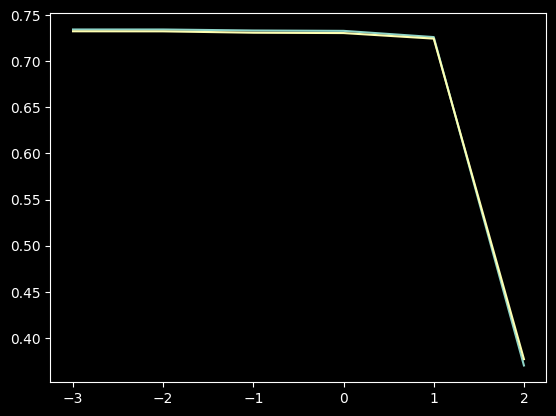

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 라쏘 회귀 alpha 비교 => 1
train_score, test_score = [], []

a_list=[0.001,0.01,0.1,1,10,100]

for a in a_list:
    lls = Lasso(alpha=a, max_iter=10000)
    lls.fit(X_train, y_train)
    train_score.append(lls.score(X_train,y_train))
    test_score.append(lls.score(X_test,y_test))

plt.plot(np.log10(a_list),train_score)
plt.plot(np.log10(a_list),test_score)

plt.show()

In [46]:
X_train.iloc[:,ll.coef_!=0].columns

Index(['Year_prd', 'Brand', 'Model', 'Mileage', 'CC'], dtype='object')

예측

In [47]:
lasso_y_hat = ll.predict(X_test)


In [48]:
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

lasso_r2 = r2_score(y_test,lasso_y_hat)
lasso_MSE = mean_squared_error(y_test,lasso_y_hat)
lasso_MAE = mean_absolute_error(y_test,lasso_y_hat)

print('R2 score: %.2f, MSE: %.2f, MAE: %.2f' %(lasso_r2, lasso_MSE, lasso_MAE))

R2 score: 0.72, MSE: 334.68, MAE: 13.59


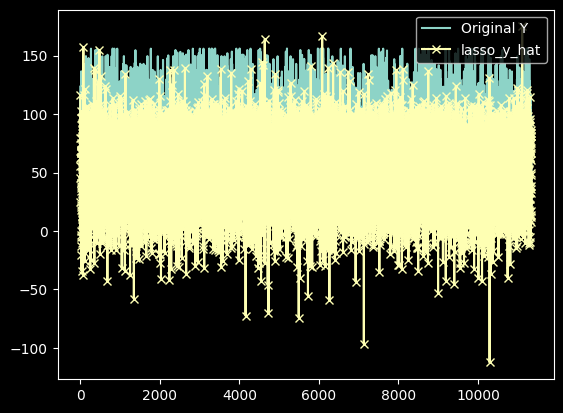

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(len(y_test)), y_test, '-', label="Original Y")
ax.plot(range(len(y_test)), lasso_y_hat, '-x', label="lasso_y_hat")

plt.legend(loc='upper right')
plt.show()

In [49]:
import pandas as pd

# 변수 영향력 확인

coeff = pd.Series(data=np.round(ll.coef_,1), index=xData.columns)

coeff.sort_values(ascending=False)

Year_prd         5.1
Model            0.1
Mileage         -0.0
CC               0.0
Fuel_CNG        -0.0
Fuel_Diesel      0.0
Fuel_Gasoline   -0.0
Fuel_Hybrid      0.0
Fuel_LPG        -0.0
Brand           -0.2
dtype: float64

오차행렬 -> 이진 일 때에만.

In [62]:
print(y_test, lasso_y_hat)

30117    123.37
22953     44.20
15494     96.20
32986     10.79
31144     51.94
          ...  
42700     99.45
33950     30.55
45744     12.87
10505     98.61
47259     20.15
Name: Price, Length: 11340, dtype: float64 [1 1 1 ... 1 1 1]


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# 0/1 cut-off(임계값) 함수

def cut_off(y, threshold):
	Y = y.copy()
	Y[Y>threshold] = 1
	Y[Y<=threshold] = 0
	return (Y.astype(int))

# 정확도 acc 함수 

def acc(cfmat):
	acc = (cfmat[0,0] + cfmat[1,1]) / np.sum(cfmat)
	return acc

lasso_y_hat = cut_off(lasso_y_hat, 0.5)
cfmat = confusion_matrix(y_test,lasso_y_hat)
print(acc(cfmat))

ValueError: Classification metrics can't handle a mix of continuous and binary targets